## Denoising AutoEncoder MNIST Example
Based on: https://medium.com/game-of-bits/denoising-autoencoders-can-reduce-noise-in-images-5b74753eaf97

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

from tensorflow.keras.datasets import mnist

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


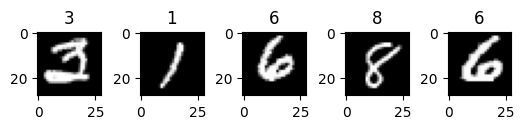

In [4]:
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))
for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

In [26]:
# Adding Noise to the dataset
def guassian_noise(image):
    r,c= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gaussian = np.random.normal(mean,sigma,(r,c))
    gaussian = gaussian.reshape(r,c)
    noisy = image + gaussian
    return noisy

def salt_and_pepper_noise(image):
    ratio = 0.9
    amount = 0.1
    noisy = np.copy(image)
    
    salt_count = np.ceil(amount * image.size * ratio)
    coords = [np.random.randint(0, i - 1, int(salt_count)) for i in image.shape]
    noisy[coords] = 1
    pepper_count = np.ceil(amount* image.size * (1. - ratio))
    coords = [np.random.randint(0, i - 1, int(pepper_count)) for i in image.shape]
    noisy[coords] = 0
    return noisy

def poisson_noise(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy

def speckle_noise(image):
    r,c = image.shape
    speckle = np.random.randn(r,c)
    speckle = speckle.reshape(r,c)        
    noisy = image + image * speckle
    return noisy    

def add_noise(image):
    p = np.random.random()
    if p <= 0.4:
        #print("Guassian")
        noisy = guassian_noise(image)
    elif p <= 0.75:
        #print("Poison")
        noisy = poisson_noise(image)
    else:
        #print("speckle")
        noisy = speckle_noise(image)
    return noisy

Corrupted Example Samples


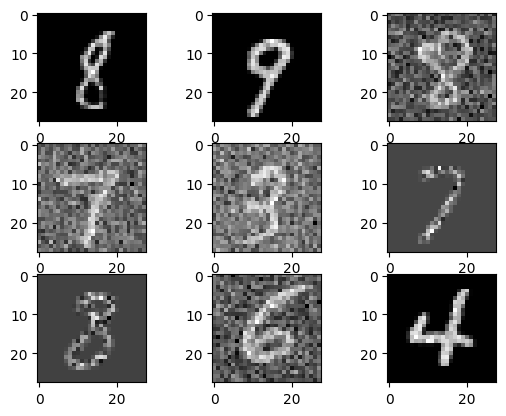

In [27]:
print ("Corrupted Example Samples")
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    noisy = add_noise(trainX[i]/255)
    plt.imshow(noisy, cmap='gray')
plt.show()

In [28]:
train_clean = [image/255 for image in trainX]
test_clean = [image/255 for image in testX]

train_noisy = [add_noise(image/255) for image in trainX]
test_noisy = [add_noise(image/255) for image in testX]

train_clean = np.reshape(train_clean, (60000, 28, 28, 1))
test_clean = np.reshape(test_clean, (10000, 28, 28, 1))

train_noisy = np.reshape(train_noisy, (60000, 28, 28, 1))
test_noisy = np.reshape(test_noisy, (10000, 28, 28, 1))

print(train_clean.shape, train_noisy.shape, test_clean.shape, test_noisy.shape)


(60000, 28, 28, 1) (60000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


In [29]:
input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

#Encoder part
encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(256, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

#Decoder Part
decoder = tensorflow.keras.layers.Conv2DTranspose(256, (3,3), activation='relu')(encoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(128, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
decoded = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [30]:
autoencoder = tensorflow.keras.models.Model(inputs=input_data, outputs=decoded)
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 3, 3, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 5, 5, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 12, 12, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,201 (5.08 MB)

 Trainable params: 1,331,201 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
autoencoder.fit(train_noisy, train_clean, epochs=30, batch_size=64, validation_data=(test_noisy, test_clean))

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 0.0433 - val_loss: 0.0134
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - loss: 0.0125 - val_loss: 0.0105
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.0102 - val_loss: 0.0096
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 9/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 0.0071 - val_loss: 0.0086
Epoch 10/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 0.0069 - val_loss: 0.0076
Epoch 11/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 12/30
938/938 ━━━━━━━━━━

Noisy test images


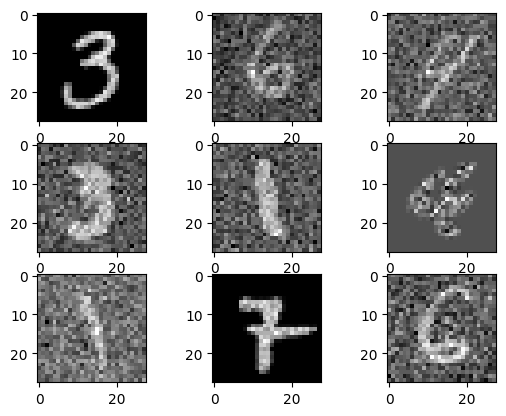

Cleaned Version(Denoising Autoencoder):) 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


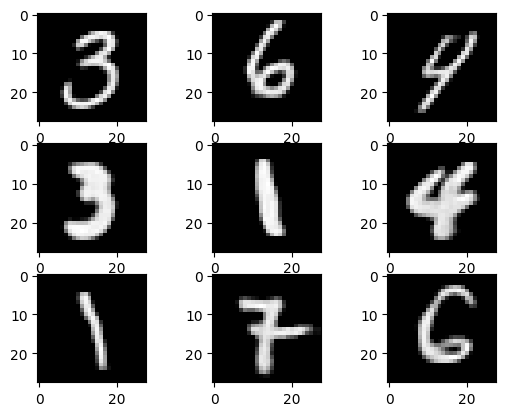

In [34]:
offset=90

print("Noisy test images")

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_noisy[i+offset,:,:, -1], cmap='gray')
plt.show()

# Reconstructed Images
print ("Cleaned Version(Denoising Autoencoder):) ")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_noisy[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()